Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

In [2]:
style.use('ggplot')

Buscando dados

In [3]:
#codigo == 13522

In [4]:
url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.13522/dados?formato=json'

In [5]:
ipca = pd.read_json(url)
ipca.head()

,data,valor
0,01/12/1980,99.25
1,01/01/1981,99.67
2,01/02/1981,103.07
3,01/03/1981,101.03
4,01/04/1981,103.27


Formantando a base

In [6]:
ipca['data'] = pd.to_datetime(ipca['data'], dayfirst=True)
ipca.set_index('data', inplace=True)
ipca.head()

,valor
data,
1980-12-01,99.25
1981-01-01,99.67
1981-02-01,103.07
1981-03-01,101.03
1981-04-01,103.27


In [7]:
ipca.index = pd.DatetimeIndex(ipca.index)

Filtrando a base

In [43]:
ipca_filtro = ipca[ipca.index.year >= 2010]
ipca_filtro.resample('m')
ipca_filtro.tail()

,valor
data,
2021-05-01,8.06
2021-06-01,8.35
2021-07-01,8.99
2021-08-01,9.68
2021-09-01,10.25


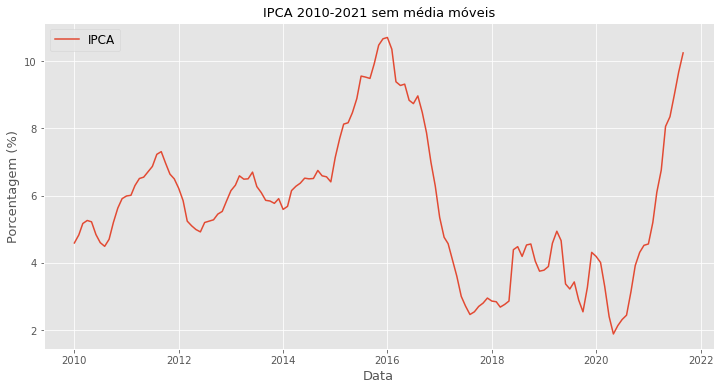

In [9]:
fig = plt.figure(figsize=(12, 6));
x, = plt.plot(ipca_filtro, label='Line 1');
plt.xlabel('Data', fontsize=13);
plt.ylabel('Porcentagem (%)', fontsize=13);
plt.title('IPCA 2010-2021 sem média móveis', fontsize=13);
plt.legend([x], ['IPCA'], loc=2, fontsize=12);

Analisando tendência

In [10]:
mm_ipca_filtro = ipca_filtro.rolling(4).mean()
mm_ipca_filtro.head(15)

,valor
data,
2010-01-01,NaN
2010-02-01,NaN
2010-03-01,NaN
2010-04-01,4.9625
2010-05-01,5.1200
2010-06-01,5.1225
2010-07-01,4.9800
2010-08-01,4.7875
2010-09-01,4.6575


In [11]:
mm_ipca_filtro.dropna(inplace=True)
mm_ipca_filtro.head()

,valor
data,
2010-04-01,4.9625
2010-05-01,5.1200
2010-06-01,5.1225
2010-07-01,4.9800
2010-08-01,4.7875


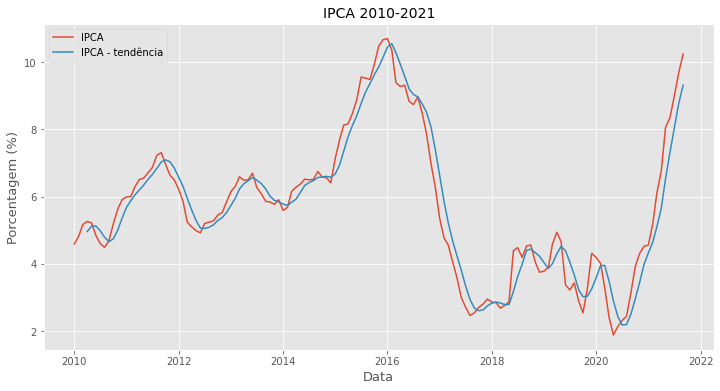

In [12]:
fig = plt.figure(figsize=(12, 6));
plt.title('IPCA 2010-2021', fontsize=14);
x, = plt.plot(ipca_filtro, label='Line 1');
y, = plt.plot(mm_ipca_filtro, label='Line 2');
plt.xlabel('Data', fontsize=13);
plt.ylabel('Porcentagem (%)', fontsize=13);
plt.legend([x, y], ['IPCA', 'IPCA - tendência']);

Analisando sazonalidade

In [13]:
diff_ipca = ipca_filtro.diff()
diff_ipca.head()

,valor
data,
2010-01-01,NaN
2010-02-01,0.24
2010-03-01,0.34
2010-04-01,0.09
2010-05-01,-0.04


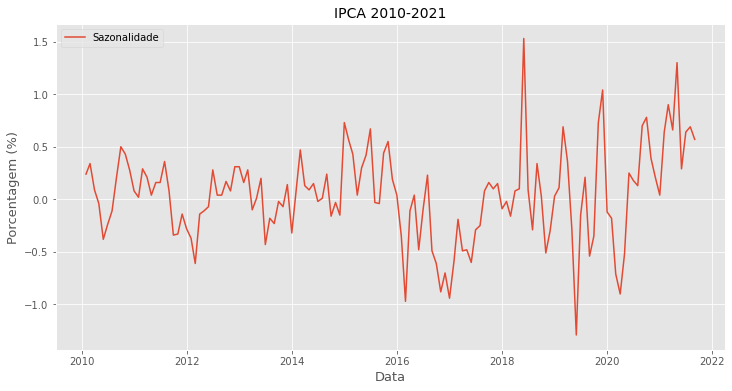

In [14]:
ig = plt.figure(figsize=(12, 6));
plt.title('IPCA 2010-2021', fontsize=14);
x, = plt.plot(diff_ipca, label='Line 1');
plt.xlabel('Data', fontsize=13);
plt.ylabel('Porcentagem (%)', fontsize=13);
plt.legend([x], ['Sazonalidade'], loc=2);

Modelos preditivos

Bibliotecas

In [15]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AR
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

Modelo Neive

In [16]:
ipca_filtro.head()

,valor
data,
2010-01-01,4.59
2010-02-01,4.83
2010-03-01,5.17
2010-04-01,5.26
2010-05-01,5.22


In [17]:
ipca_filtro['neive'] = ipca_filtro.shift()
ipca_filtro.dropna(axis=0, inplace=True)
ipca_filtro.head()

,valor,neive
data,,
2010-02-01,4.83,4.59
2010-03-01,5.17,4.83
2010-04-01,5.26,5.17
2010-05-01,5.22,5.26
2010-06-01,4.84,5.22


Gráfico: dados versus modelo

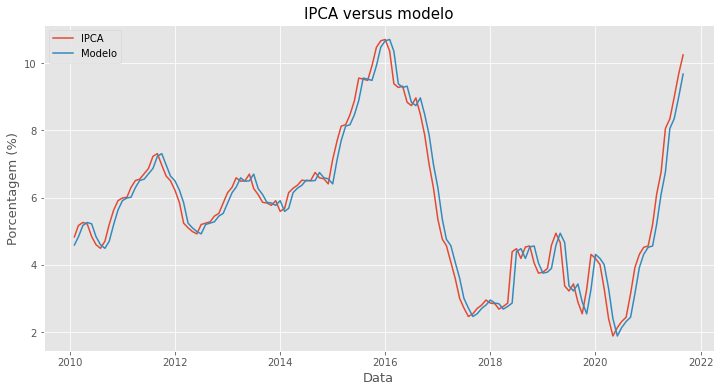

In [18]:
plt.figure(figsize=(12, 6))
x, = plt.plot(ipca_filtro.valor, label='Line 1');
y, = plt.plot(ipca_filtro.neive, label='Line 2');
plt.title('IPCA versus modelo', fontsize=15);
plt.xlabel('Data', fontsize=13);
plt.ylabel('Porcentagem (%)', fontsize=13);
plt.legend([x, y], ['IPCA', 'Modelo']);

Validação do modelo

Erro médio quadrático 

In [19]:
erro1 = ((ipca_filtro.valor - ipca_filtro.neive) ** 2).mean()
erro1

0.1879814285714286

Modelo AutoRegressivo

In [20]:
ipca_filtro.head()
ipca_filtro['x1'] =  ipca_filtro.neive
ipca_filtro.head()

,valor,neive,x1
data,,,
2010-02-01,4.83,4.59,4.59
2010-03-01,5.17,4.83,4.83
2010-04-01,5.26,5.17,5.17
2010-05-01,5.22,5.26,5.26
2010-06-01,4.84,5.22,5.22


Gráfico de dispersão

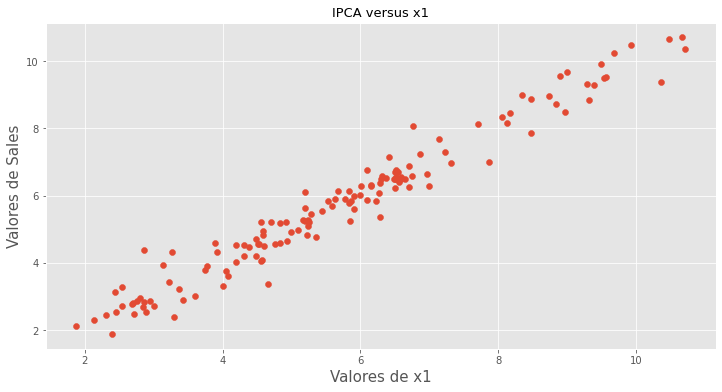

In [21]:
plt.figure(figsize=(12, 6))
plt.scatter(ipca_filtro.x1, ipca_filtro.valor);
plt.title('IPCA versus x1', fontsize=13);
plt.xlabel('Valores de x1', fontsize=15);
plt.ylabel('Valores de Sales', fontsize=15);

Modelo AR(1) - regressão linear simples

In [22]:
x = ipca_filtro.x1.values
y = np.array(ipca_filtro.valor)

In [23]:
reg = LinearRegression().fit(x.reshape(-1, 1), y)
prev = reg.predict(x.reshape(-1, 1))
erro2 = ((y - prev) ** 2).mean() 
erro2

0.1862194653158614

Gráfico: linha de regressão

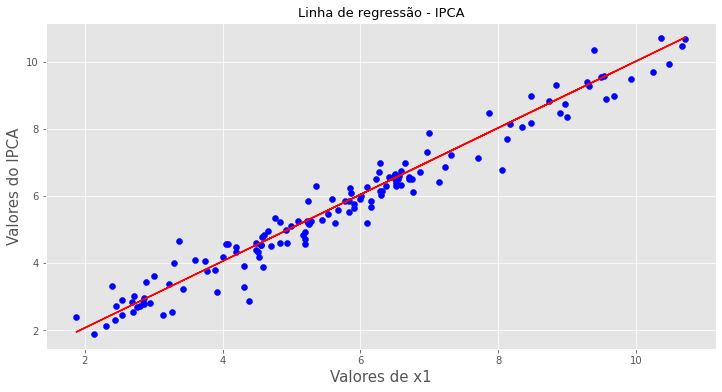

In [24]:
plt.figure(figsize=(12, 6));
plt.scatter(ipca_filtro.valor, ipca_filtro.x1, color='blue');
plt.plot(x, prev, color='r')
plt.title('Linha de regressão - IPCA', fontsize=13);
plt.xlabel('Valores de x1', fontsize=15);
plt.ylabel('Valores do IPCA', fontsize=15);

Gráfico: IPCA versus AR(1)

In [25]:
ipca_filtro['ar_1'] = prev
ipca_filtro.head()

,valor,neive,x1,ar_1
data,,,,
2010-02-01,4.83,4.59,4.59,4.636303
2010-03-01,5.17,4.83,4.83,4.875010
2010-04-01,5.26,5.17,5.17,5.213179
2010-05-01,5.22,5.26,5.26,5.302694
2010-06-01,4.84,5.22,5.22,5.262910


<Figure size 864x432 with 0 Axes>

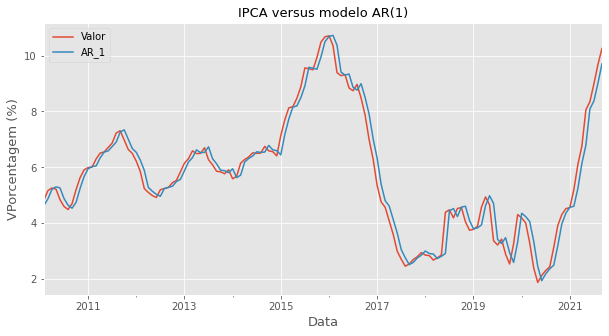

In [26]:
plt.figure(figsize=(12, 6));
ipca_filtro[['valor', 'ar_1']].plot(figsize=(10, 5));
plt.title('IPCA versus modelo AR(1)', fontsize=13);
plt.xlabel('Data', fontsize=13);
plt.ylabel('VPorcentagem (%)', fontsize=13);
plt.legend(['Valor', 'AR_1'], loc=2);

Outra forma de prever valores futuros

In [29]:
ar_2 = AR(ipca_filtro.valor, freq='MS').fit(2)

In [32]:
erro3 = (ar_2.resid ** 2).mean()
erro3

0.13114531988741776

In [33]:
ar_2.resid.describe()

count    1.380000e+02
mean    -2.825437e-15
std      3.634592e-01
min     -1.174696e+00
25%     -1.722750e-01
50%     -2.148015e-02
75%      1.939769e-01
max      1.390710e+00
dtype: float64

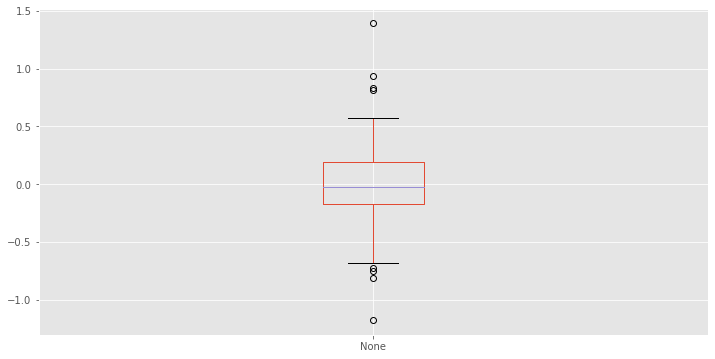

In [37]:
#plt.figure(figzise=(12, 6));
ar_2.resid.plot(kind='box', figsize=(12, 6));

Text(0.5, 1.0, 'Histograma dos resíduos')

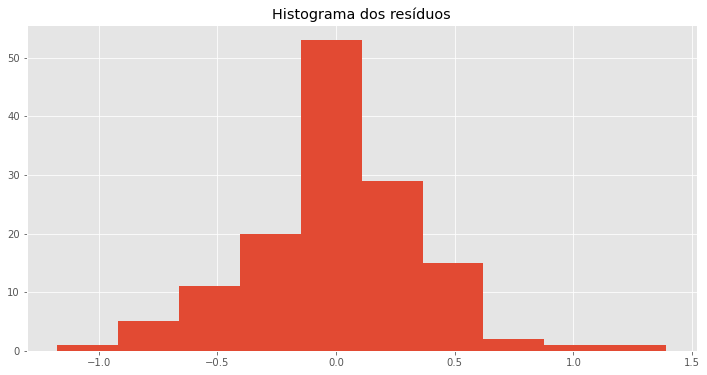

In [40]:
ar_2.resid.hist(figsize=(12, 6));
plt.title('Histograma dos resíduos')

In [44]:
ar_3 = AR(ipca_filtro, freq='MS').fit(3)

In [45]:
erro4 = (ar_3.resid ** 2).mean()
erro4

0.13097785811293206

In [49]:
ipca_filtro['ar_3'] = ar_3.predict()
ipca_filtro.dropna(axis=0, inplace=True)
ipca_filtro.head()

,valor,ar_3
data,,
2010-04-01,5.26,5.386929
2010-05-01,5.22,5.326891
2010-06-01,4.84,5.221781
2010-07-01,4.60,4.658516
2010-08-01,4.49,4.517065


<Figure size 864x432 with 0 Axes>

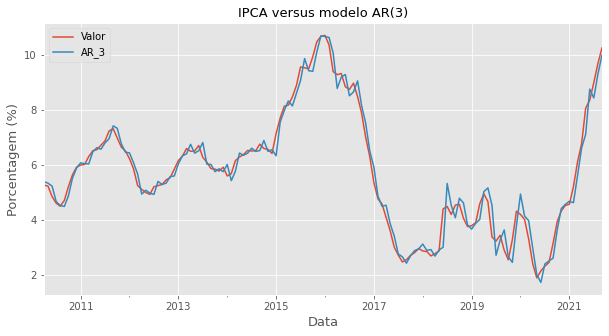

In [50]:
plt.figure(figsize=(12, 6));
ipca_filtro[['valor', 'ar_3']].plot(figsize=(10, 5));
plt.title('IPCA versus modelo AR(3)', fontsize=13);
plt.xlabel('Data', fontsize=13);
plt.ylabel('Porcentagem (%)', fontsize=13);
plt.legend(['Valor', 'AR_3'], loc=2);

Prevendo o mês seguinte

In [51]:
ipca_filtro.tail()

,valor,ar_3
data,,
2021-05-01,8.06,7.102606
2021-06-01,8.35,8.752292
2021-07-01,8.99,8.429177
2021-08-01,9.68,9.293962
2021-09-01,10.25,9.984854


In [76]:
ar_3.predict(start='2021-10-01', end='2021-10-01')

2021-10-01    10.471118
Freq: MS, dtype: float64

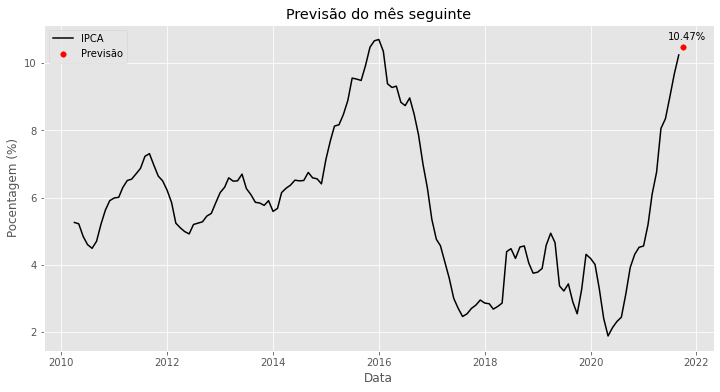

In [77]:
plt.figure(figsize=(12, 6));
plt.plot(ipca_filtro.valor, color='black');
plt.title('Previsão do mês seguinte')
plt.xlabel('Data')
plt.ylabel('Pocentagem (%)')
forecast = ar_3.predict(start='2021-10-01', end='2021-10-01');
plt.scatter(forecast.index, forecast.values, color='r', s=30);
plt.text(pd.DatetimeIndex(['2021-06-15']), 10.7, '10.47%');
plt.legend(['IPCA', 'Previsão']);